### 대규모 데이터셋 수집하기
#### 대규모 말뭉치 구축의 어려움

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# GPT vs GPT-2 비교
# GPT : BookCorpus에서 훈련
# GPT-2 : 웹페이지, 블로그, 레딧에 링크된 뉴스 기사에서 훈련
from transformers import pipeline, set_seed

generation_gpt = pipeline('text-generation', model = 'openai-gpt')
generation_gpt2 = pipeline('text-generation', model = 'gpt2')

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# 파라미터 개수 출력
def model_size(model) :
    return sum(t.numel() for t in model.parameters())

print(f"GPT  크기: {model_size(generation_gpt.model)/1000**2:.1f}M parameters")
print(f"GPT2 크기: {model_size(generation_gpt2.model)/1000**2:.1f}M parameters")

GPT  크기: 116.5M parameters
GPT2 크기: 124.4M parameters


In [4]:
def enum_pipeline_ouputs(pipe, prompt, num_return_sequences):
    out = pipe(prompt, num_return_sequences=num_return_sequences,
               clean_up_tokenization_spaces=True)
    return "\n".join(f"{i+1}." + s["generated_text"] for i, s in enumerate(out))

prompt = "\nWhen they came back"
print("GPT 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt, prompt, 3))
print("")
print("GPT-2 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt2, prompt, 3))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT 자동 완성:
1.
When they came back, he could not take his eyes off the fire pit. he could also not look at lily and luke. he could not look at them with fear or disgust. his breath became shallow and shallow, and he nearly hyperventilated when
2.
When they came back to her, she began to cry softly, her shoulders shaking. 
 i put my arms around her and held her tight. " it's okay, mom. it's all gon na be okay. " 
 i held her and
3.
When they came back. 
 " it's okay. i was just taking a shower, " she said. 
 " but i need to wash your hair. " 
 " that doesn't count. it's not really mine. " 
 he kissed

GPT-2 자동 완성:
1.
When they came back to the farm it was clear they had just started to pick them up. It was an early morning call and they took me aside, said 'We're on the way. Let's get out there and do something interesting,'"
2.
When they came back, they were in a hurry, hoping for the news report of the police report, but they had no idea how to proceed. The next day, however, they were

GPT : 로맨스로 편향된 부분 있음, 남자와 여자의 낭만적인 대화로 보임  
GPT-2 : 레딧 기사에 연결된 웹 텍스트에서 훈련되어 블로그 같은 내용이나 모험적인 요소를 담고 있고 중립적인 they 사용  

* 구글 빅쿼리로 데이터셋 만들기

In [5]:
from datasets import load_dataset, DownloadConfig

remote_dataset = load_dataset('transformersbook/codeparrot', split="train",
                              streaming=True)

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

### 토크나이저 구축하기

In [6]:
from transformers import AutoTokenizer

def tok_list(tokenizer, string):
    input_ids = tokenizer(string, add_special_tokens=False)["input_ids"]
    return [tokenizer.decode(tok) for tok in input_ids]

tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base")
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base")

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
print(f'"sex"에 대한 T5 토큰: {tok_list(tokenizer_T5,"sex")}')
print(f'"being"에 대한 CamemBERT 토큰: {tok_list(tokenizer_camembert,"being")}')

"sex"에 대한 T5 토큰: ['', 's', 'ex']
"being"에 대한 CamemBERT 토큰: ['be', 'ing']


짧고, 평범한 단어를 부분으로 나누면 모델에 입력되는 시퀀스 길이가 늘어나 비효율적  

* 토크나이저 성능 측정하기
    * 부분단어 생산력 : 토큰화된 단어마다 생성되는 부분단어의 평균 개수 계산
    * 연속 단어의 비율 : 말뭉치에서 적어도 두 개의 부분 토큰으로 분할된 토큰화된 단어의 비율
    * 커버리지 측정값 : 토큰화된 말뭉치에서 알 수 없는 단어나 거의 사용되지 않는 토큰의 비율
    
* 파이썬 코드를 위한 토크나이저

In [8]:
from transformers import AutoTokenizer

python_code = r"""def say_hello():
    print("Hello, World!")
# Print it
say_hello()
"""
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!"', ')', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


In [9]:
print(tokenizer.backend_tokenizer.normalizer)
# GPT-2는 정규화 사용하지 않음

None


In [10]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():', (13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello', (28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ċ', (43, 44)), ('#', (44, 45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('say', (55, 58)), ('_', (58, 59)), ('hello', (59, 64)), ('()', (64, 66)), ('Ċ', (66, 67))]


토크나이저는 문자열과 토큰 사이를 전환하는 데 매우 유용한 오프셋트래킹 기능이 있다. 입력 문자열에 대한 모든 연산이 추적되기에 토큰화 이후 토큰이 입력 문자열의 어떤 부분에 해당하는지 정확하게 알 수 있다.  

숫자는 단순히 토큰이 유래된 원본 문자열의 위치로, 일부 문자가 정규화 단계에서 삭제되더라도 각 토큰을 원본 문자열의 해당 부분에 연결 가능  
기이한 문자는 유니코드 문자를 바이트의 시퀀스로 변환하여 생긴 것  
(`Ċ` : 줄바꿈 , `Ġ` : 공백)

In [11]:
a, e = u"a", u"€"
byte = ord(a.encode("utf-8"))
print(f'`{a}`는 단일 바이트 `{a.encode("utf-8")}`로 인코딩됩니다: {byte}')
byte = [ord(chr(i)) for i in e.encode("utf-8")]
print(f'`{e}`는 세 바이트 `{e.encode("utf-8")}`로 인코딩됩니다: {byte}')

`a`는 단일 바이트 `b'a'`로 인코딩됩니다: 97
`€`는 세 바이트 `b'\xe2\x82\xac'`로 인코딩됩니다: [226, 130, 172]


In [12]:
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

print(f'기본 어휘 사전 크기: {len(base_vocab)}')
print(f'첫 번째 원소: `{base_vocab[0]}`, last element: `{base_vocab[-1]}`')

기본 어휘 사전 크기: 256
첫 번째 원소: `!`, last element: `Ń`


In [13]:
# BPE 문자 매핑의 예
import pandas as pd
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

examples = [
    ['Regular characters', '`a` and `?`', f'{ord("a")} and {ord("?")}' , f'`{byte_to_unicode_map[ord("a")]}` and `{byte_to_unicode_map[ord("?")]}`'],
    ['Nonprintable control character (carriage return)', '`U+000D`', f'13', f'`{byte_to_unicode_map[13]}`'],
    ['A space', '` `', f'{ord(" ")}', f'`{byte_to_unicode_map[ord(" ")]}`'],
    ['A nonbreakable space', '`\\xa0`', '160', f'`{byte_to_unicode_map[ord(chr(160))]}`'],
    ['A newline character', '`\\n`', '10', f'`{byte_to_unicode_map[ord(chr(10))]}`'],
]

pd.DataFrame(examples, columns = ['Description', 'Character', 'Bytes', 'Mapped bytes'])

,Description,Character,Bytes,Mapped bytes
0,Regular characters,`a` and `?`,97 and 63,`a` and `?`
1,Nonprintable control character (carriage return),`U+000D`,13,`č`
2,A space,` `,32,`Ġ`
3,A nonbreakable space,`\xa0`,160,`ł`
4,A newline character,`\n`,10,`Ċ`


In [14]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():', (13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello', (28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ċ', (43, 44)), ('#', (44, 45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('say', (55, 58)), ('_', (58, 59)), ('hello', (59, 64)), ('()', (64, 66)), ('Ċ', (66, 67))]


In [15]:
print(f"어휘 사전의 크기: {len(tokenizer)}")

어휘 사전의 크기: 50257


In [16]:
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!"', ')', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


* 토크나이저 훈련하기

In [17]:
# GPT-2 어휘사전에서 가장 긴 단어
tokens = sorted(tokenizer.vocab.items(), key=lambda x: len(x[0]), reverse=True)
print([f'{tokenizer.convert_tokens_to_string([t])}' for t, _ in tokens[:8]])

['ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ', ' =================================================================', ' ----------------------------------------------------------------', '----------------------------------------------------------------', '................................................................', '================================================================', '________________________________________________________________', 'ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ']


In [18]:
# 어휘사전의 마지막에 등록된 단어
tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True)
print([f'{tokenizer.convert_tokens_to_string([t])}' for t, _ in tokens[:12]]);

['<|endoftext|>', ' gazed', ' informants', ' Collider', ' regress', 'ominated', ' amplification', 'Compar', '…."', ' (/', 'Commission', ' Hitman']


<|endoftext|> : 텍스트 시퀀스의 끝 지정할 때 사용하는 특수 토큰으로, BPE 어휘사전이 구축된 후 추가됨

In [19]:
from tqdm.auto import tqdm

length = 100000
dataset_name = 'transformersbook/codeparrot-train'
dataset = load_dataset(dataset_name, split="train", streaming=True)
iter_dataset = iter(dataset)

def batch_iterator(batch_size=10):
    for _ in tqdm(range(0, length, batch_size)):
        yield [next(iter_dataset)['content'] for _ in range(batch_size)]

new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(),
                                                  vocab_size=12500,
                                                  initial_alphabet=base_vocab)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
# BPE 알고리즘이 만든 첫 단어
# 256바이트는 건너뛰고 그다음에 추가된 첫 토큰
tokens = sorted(new_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False)
print([f'{tokenizer.convert_tokens_to_string([t])}' for t, _ in tokens[257:280]]);

['  ', '    ', '   ', '        ', 'se', 'in', '       ', 're', 'on', 'te', '\n       ', '\n        ', 'or', 'st', 'de', '\n   ', 'th', 'le', ' =', 'lf', 'self', 'me', 'al']


In [22]:
# 마지막 단어
print([f'{new_tokenizer.convert_tokens_to_string([t])}' for t,_ in tokens[-12:]]);

[' capt', ' embedded', ' regarding', 'Bundle', '355', ' recv', ' dmp', ' vault', ' Mongo', ' possibly', 'implementation', 'Matches']


In [23]:
print(new_tokenizer(python_code).tokens())

['def', 'Ġs', 'ay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',', 'ĠWor', 'ld', '!")', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 's', 'ay', '_', 'hello', '()', 'Ċ']


In [24]:
import keyword

print(f'파이썬 전체 예약어 개수: {len(keyword.kwlist)}')
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer.vocab:
        print(f'예약어 `{keyw}`는 어휘 사전에 없습니다.')

파이썬 전체 예약어 개수: 35
예약어 `await`는 어휘 사전에 없습니다.
예약어 `finally`는 어휘 사전에 없습니다.
예약어 `nonlocal`는 어휘 사전에 없습니다.


finally 같이 매우 자주 등장하는 예약어가 어휘사전에 없다. 데이터셋에서 더 많은 샘플을 가져와 더 큰 어휘사전을 만들어야.

In [25]:
length = 200000
new_tokenizer_larger = tokenizer.train_new_from_iterator(batch_iterator(),
    vocab_size=32768, initial_alphabet=base_vocab)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [26]:
# 마지막 토큰
tokens = sorted(new_tokenizer_larger.vocab.items(), key=lambda x: x[1],
                reverse=False)
print([f'{tokenizer.convert_tokens_to_string([t])}' for t, _ in tokens[-12:]]);

[" '<?", 'Functional', ' Images', 'encoders', ' bibrec', ' OPTIONAL', ' rdclass', 'SocketAddressTag', '资金', 'DEPLOYMENT', '经纪公司代码', ")'],"]


In [27]:
print(new_tokenizer_larger(python_code).tokens())
# 들여쓰기가 어휘사전에 유지됨

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!")', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


In [28]:
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer_larger.vocab:
        print(f'예약어 `{keyw}`는 어휘 사전에 없습니다.')

예약어 `nonlocal`는 어휘 사전에 없습니다.


드문 단어라 어휘사전에 없는 것이 합당함

### 밑바닥부터 모델 훈련하기
#### 사전 훈련 목표
* 코잘 언어 모델링
    * 코드 샘플 시작 부분을 모델에게 제공하고 코드의 나머지 부분을 생성해 완성하라고 요청하는 것
    * 레이블이 없는 데이터셋을 사용하는 자기 지도 훈련 목표
* 마스크드 언어 모델링
    * 모델에게 잡음이 섞인 코드 샘플을 주고 깨끗한 원본 샘플을 재구성하라고 요청하는 자기 지도 훈련 목표
* 시퀀스-투-시퀀스 훈련
    * 정규식 같은 수동 규칙으로 주석이나 독스트링을 코드에서 분리해 레이블링된 데이터셋으로 사용하도록 (코드, 주석) 쌍의 대규모 데이터셋을 구축하는 작업
    
#### 모델 초기화

In [29]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('transformersbook/codeparrot')
config = AutoConfig.from_pretrained("gpt2", vocab_size=len(tokenizer))
model = AutoModelForCausalLM.from_config(config)

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
print(f'GPT-2 (xl) 크기: {model_size(model)/1000**2:.1f}M parameters')

GPT-2 (xl) 크기: 111.0M parameters


#### 데이터로더 구축하기
시퀀스 마지막 부분을 많이 잃지 않도록, 여러 샘플을 토큰화한 다음 특수한 EOS 토큰으로 연결해 매우 긴 시퀀스를 만든다. 이 시퀀스를 동일한 크기의 청크로 나누면 마지막 데이터에서 손실되는 부분이 미미하다.

<br>

input_characters = number_of_sequences * sequence_length * characters_per_token  
* input_characters : 토크나이저에 입력된 문자열에 있는 문자의 개수
* number_of_sequences : 토크나이저로부터 얻으려는 시퀀스의 개수
* sequence_length : 토크나이저가 반환한 각 시퀀스의 토큰 개수
* characters_per_token : 사전에 추정해야 하는 각 출력 토큰의 평균 문자 개수

In [31]:
# 토큰의 평균 문자 길이
examples, total_characters, total_tokens = 500, 0, 0
dataset = load_dataset('transformersbook/codeparrot-train', split='train',
                       streaming=True)

for _, example in tqdm(zip(range(examples), iter(dataset)), total=examples):
    total_characters += len(example['content'])
    total_tokens += len(tokenizer(example['content']).tokens())

characters_per_token = total_characters / total_tokens

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2605 > 1024). Running this sequence through the model will result in indexing errors


In [32]:
print(characters_per_token)

3.6233025034779565


In [33]:
import torch
from torch.utils.data import IterableDataset

class ConstantLengthDataset(IterableDataset):
    
    def __init__(self, tokenizer, dataset, seq_length=1024,
                 num_of_sequences=1024, chars_per_token=3.6):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.eos_token_id
        self.dataset = dataset
        self.seq_length = seq_length
        self.input_characters = seq_length * chars_per_token * num_of_sequences
    
    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.input_characters:
                    m=f"Buffer full: {buffer_len}>={self.input_characters:.0f}"
                    print(m)
                    break
                try:
                    m=f"Fill buffer: {buffer_len}<{self.input_characters:.0f}"
                    print(m)
                    buffer.append(next(iterator)["content"])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    iterator = iter(self.dataset)

            all_token_ids = []
            tokenized_inputs = self.tokenizer(buffer, truncation=False)
            for tokenized_input in tokenized_inputs['input_ids']:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])
            
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    yield torch.tensor(input_ids)

In [34]:
shuffled_dataset = dataset.shuffle(buffer_size=100)
constant_length_dataset = ConstantLengthDataset(tokenizer, shuffled_dataset,
                                                num_of_sequences=10)
dataset_iterator = iter(constant_length_dataset)

lengths = [len(b) for _, b in zip(range(5), dataset_iterator)]
print(f"시퀀스 길이: {lengths}")

Fill buffer: 0<36864
Fill buffer: 1381<36864
Fill buffer: 5239<36864
Fill buffer: 19527<36864
Fill buffer: 24263<36864
Fill buffer: 25338<36864
Buffer full: 40809>=36864
시퀀스 길이: [1024, 1024, 1024, 1024, 1024]


#### 훈련 루프 정의하기

In [35]:
from argparse import Namespace

# 작은 모델에 해당하는 파라미터
config = {"train_batch_size": 2, # 12
          "valid_batch_size": 2, # 12
          "weight_decay": 0.1,
          "shuffle_buffer": 1000,
          "learning_rate": 2e-4, # 5e-4
          "lr_scheduler_type": "cosine",
          "num_warmup_steps": 750, # 2000
          "gradient_accumulation_steps": 16, # 1
          "max_train_steps": 50000, # 150000
          "max_eval_steps": -1,
          "seq_length": 1024,
          "seed": 1,
          "save_checkpoint_steps": 50000} # 15000

args = Namespace(**config)

In [36]:
from torch.utils.tensorboard import SummaryWriter
import logging
import wandb

def setup_logging(project_name):
    logger = logging.getLogger(__name__)
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO, handlers=[
        logging.FileHandler(f"log/debug_{accelerator.process_index}.log"),
        logging.StreamHandler()])
    if accelerator.is_main_process: # 로깅 한 번만 설정
        wandb.init(project=project_name, config=args)
        run_name = wandb.run.name
        tb_writer = SummaryWriter()
        tb_writer.add_hparams(vars(args), {'0': 0})
        logger.setLevel(logging.INFO)
        datasets.utils.logging.set_verbosity_debug()
        transformers.utils.logging.set_verbosity_info()
    else:
        tb_writer = None
        run_name = ''
        logger.setLevel(logging.ERROR)
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    return logger, tb_writer, run_name

In [37]:
def log_metrics(step, metrics):
    logger.info(f"Step {step}: {metrics}")
    if accelerator.is_main_process:
        wandb.log(metrics)
        [tb_writer.add_scalar(k, v, step) for k, v in metrics.items()]

In [38]:
from torch.utils.data.dataloader import DataLoader

def create_dataloaders(dataset_name):
    train_data = load_dataset(dataset_name+'-train', split="train",
                              streaming=True)
    train_data = train_data.shuffle(buffer_size=args.shuffle_buffer,
                                    seed=args.seed)
    valid_data = load_dataset(dataset_name+'-valid', split="validation",
                              streaming=True)
    
    train_dataset = ConstantLengthDataset(tokenizer, train_data,
                                          seq_length=args.seq_length)
    valid_dataset = ConstantLengthDataset(tokenizer, valid_data,
                                          seq_length=args.seq_length)
    
    train_dataloader=DataLoader(train_dataset, batch_size=args.train_batch_size)
    eval_dataloader=DataLoader(valid_dataset, batch_size=args.valid_batch_size)
    return train_dataloader, eval_dataloader

In [39]:
# 최적화
# LayerNorm 가중치에는 가중치 감쇠 적용 X
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [{'params': params_with_wd, 'weight_decay': args.weight_decay},
            {'params': params_without_wd, 'weight_decay': 0.0}]

In [40]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch, labels=batch)
        loss = outputs.loss.repeat(args.valid_batch_size)
        losses.append(accelerator.gather(loss))
        if args.max_eval_steps > 0 and step >= args.max_eval_steps: break
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = torch.tensor(float("inf"))
    return loss.item(), perplexity.item()

### 결과 및 분석

In [41]:
from transformers import pipeline, set_seed

model_ckpt = 'transformersbook/codeparrot-small'
generation = pipeline('text-generation', model=model_ckpt)

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\knuyh\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [43]:
import re
from transformers import set_seed 

def first_block(string):
    return re.split('\nclass|\ndef|\n#|\n@|\nprint|\nif', string)[0].rstrip()

def complete_code(pipe, prompt, max_length=64, num_completions=4, seed=1):
    set_seed(seed)
    gen_kwargs = {"temperature":0.4, "top_p":0.95, "top_k":0, "num_beams":1,
                  "do_sample":True,}
    code_gens = generation(prompt, num_return_sequences=num_completions, 
                            max_length=max_length, **gen_kwargs)
    code_strings = []
    for code_gen in code_gens:
        generated_code = first_block(code_gen['generated_text'][len(prompt):])
        code_strings.append(generated_code)
    print(('\n'+'='*80 + '\n').join(code_strings))

In [56]:
# 사각형 면적 계산
prompt = '''def area_of_rectangle(a: float, b: float):
    """Return the area of the rectangle."""'''
complete_code(generation, prompt)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return (a / b) * (a + b) / 2.0

    return a * b

    return a / b

    return a / b


In [58]:
# HTML에서 URL 추출
prompt = '''def get_urls_from_html(html):
    """Get all embedded URLs in a HTML string."""'''
complete_code(generation, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return [url for url in re.findall(r'<a href="(http://[^"]+\.html)"', html)]

    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

    return [url for url in re.findall(r'<a href="(.*?)" class="url">', html)]


In [59]:
import requests

def get_urls_from_html(html):
    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

print(" | ".join(get_urls_from_html(requests.get('https://hf.co/').text)))

/chat | /models | /spaces/black-forest-labs/FLUX.1-schnell | /spaces/black-forest-labs/FLUX.1-dev | /spaces/stabilityai/stable-fast-3d | /spaces/SkalskiP/florence-sam | /spaces/KwaiVGI/LivePortrait | /spaces | /datasets | /enterprise | /enterprise | /enterprise | /enterprise | /enterprise | /enterprise | /docs/transformers | /docs/diffusers | /docs/safetensors | /docs/huggingface_hub | /docs/tokenizers | /docs/peft | /docs/transformers.js | /docs/timm | /docs/trl | /docs/datasets | /docs/text-generation-inference | /docs/accelerate


In [ ]:
# 파이썬 함수를 넘파이를 사용하는 함수로 바꾸기
model_ckpt = 'transformersbook/codeparrot'
generation = pipeline('text-generation', model=model_ckpt)

prompt = '''# a function in native python:
def mean(a):
    return sum(a)/len(a)

# the same function using numpy:
import numpy as np
def mean(a):'''
complete_code(generation, prompt, max_length=64)

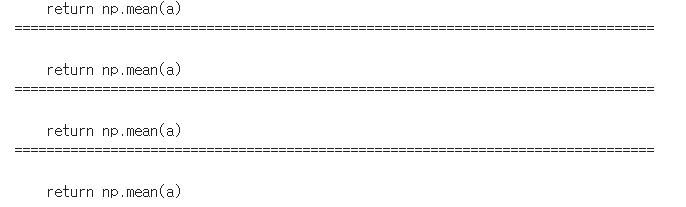

In [ ]:
# 사이킷런 모델 생성
prompt = '''X = np.random.randn(100, 100)
y = np.random.randint(0, 1, 100)

# fit random forest classifier with 20 estimators'''
complete_code(generation, prompt, max_length=96)

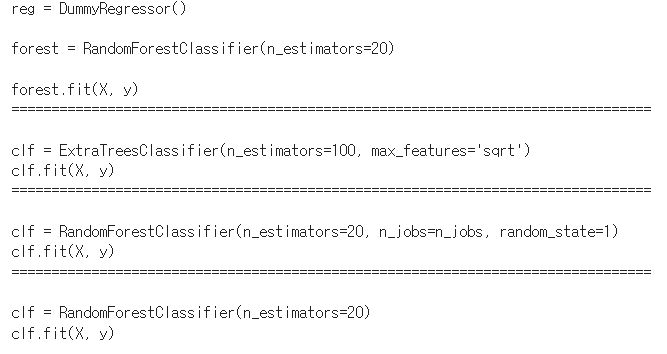